In [30]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [31]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [32]:
# MNIST Network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
base = 10
# MNIST Dataset (deterministic)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create datasets with fixed generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False, generator=g)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [34]:
# First Model
mnist_model = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_losses, trained_mnist = train_model(mnist_model, mnist_train_loader, mnist_criterion, mnist_optimizer, num_epochs=base, seed=42, verbose=True)
print(f"{mnist_losses[-5:]}")

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
[0.08905661493085071, 0.08035349289581094, 0.07134926824461617, 0.06697554315945578, 0.06090976738606206]


In [35]:
base_epochs = 10
extra_epochs = 1
index = 0
k = 5

# First Model
mnist_model = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_losses_base, trained_mnist_base = train_model(mnist_model, mnist_train_loader, mnist_criterion, mnist_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(f"{mnist_losses_base[-5:]}")

mnist_model2 = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer_v2 = optim.Adam(mnist_model2.parameters(), lr=0.001)
mnist_losses_base, trained_mnist2 = train_model(mnist_model2, mnist_train_loader, mnist_criterion, mnist_optimizer_v2, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{mnist_losses_base[-5:]}")

mnist_inputs, mnist_activations, mnist_outputs = get_activations(trained_mnist_base, mnist_train_loader, dataset_type='mnist')
single_mnist_inputs, single_mnist_activations, single_mnist_outputs = get_activations(trained_mnist_base, mnist_test_loader, dataset_type='mnist', indices=index)
indices_mnist, distances_mnist = find_knn(mnist_activations, single_mnist_activations, k=k, metric='l2')
filtered_mnist_loader, filtered_size = create_filtered_dataloader(mnist_train_loader, exclude_indices=indices_mnist, batch_size=64, shuffle=False)

mnist_model3 = MNISTNet()
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer_filter = optim.Adam(mnist_model3.parameters(), lr=0.001)
mnist_losses_base, trained_mnist_filter = train_model(mnist_model3, filtered_mnist_loader, mnist_criterion, mnist_optimizer_filter, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{mnist_losses_base[-5:]}")

mnist_losses_base, trained_mnist_filter = train_model(mnist_model3, filtered_mnist_loader, mnist_criterion, mnist_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(f"{mnist_losses_base[-1:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.08905661493085071, 0.08035349289581094, 0.07134926824461617, 0.06697554315945578, 0.06090976738606206]
All seeds set to: 42
Model weights initialized with seed: 42
[0.08035349289581094, 0.07134926824461617, 0.06697554315945578, 0.06090976738606206, 0.05695899648716824]
All seeds set to: 42
Model weights initialized with seed: 42
[0.08025608604008988, 0.07458669034670964, 0.06644530053057997, 0.05855957530111715, 0.05401887138050408]
[0.047569337115958434]


In [36]:
predictions_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist_base, mnist_test_loader, dataset_type='mnist', indices=index)  # Single index
predictions_mnist_v2, probabilities_mnist_v2, predicted_classes_mnist_v2, sample_targets_mnist_v2 = predict_and_show(trained_mnist2, mnist_test_loader, dataset_type='mnist', indices=index)  # Single index
predictions_mnist_filter, probabilities_mnist_filter, predicted_classes_mnist_filter, sample_targets_mnist_filter = predict_and_show(trained_mnist_filter, mnist_test_loader, dataset_type='mnist', indices=index)  # Single index

print(f"{nn.CrossEntropyLoss()(predictions_mnist, sample_targets_mnist):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_mnist_v2, sample_targets_mnist_v2):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_mnist_filter, sample_targets_mnist_filter):.8f}")
print(f"Difference: {nn.CrossEntropyLoss()(predictions_mnist_filter, sample_targets_mnist_filter).item() - nn.CrossEntropyLoss()(predictions_mnist_v2, sample_targets_mnist_v2).item():.8f}")

MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
0      7      7      1.0000      
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
0      7      7      1.0000      
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
0      7      7      1.0000      
0.00000060
0.00000072
0.00000012
Difference: -0.00000060


In [37]:
# # Function to calculate CrossEntropy loss for different k and indices (Iris version)
# def continue_cross_entropy_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=base_epochs, extra_epochs=extra_epochs, metric='l2'):
#     """
#     For each k and index:
#       - find k nearest neighbors for the test sample using activations from the base model
#       - create a filtered dataloader excluding those k neighbours
#       - train a fresh IrisNet on the full training set for `base_epochs`
#       - continue training that fresh model for `extra_epochs` on the filtered set
#       - evaluate cross-entropy on the test sample and store the loss

#     Returns two dicts:
#       - cross_results: {'closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'} mapping k -> list of losses (one per index)
#       - dist_results: {'closest_distances', 'last_distances', 'random_distances'} mapping k -> list of distance-lists (k distances per sample)
#     """
#     cross_results = {
#         'closest_cross_entropy': {},
#         'last_cross_entropy': {},
#         'random_cross_entropy': {}
#     }

#     dist_results = {
#         'closest_distances': {},
#         'last_distances': {},
#         'random_distances': {}
#     }

#     # Ensure we have the base activations available
#     try:
#         activations_ref = iris_activations
#     except NameError:
#         activations_ref = globals().get('iris_activations', None)
#         if activations_ref is None:
#             raise RuntimeError("iris_activations not found. Run the activation capture cell first.")

#     for k in list_of_k:
#         print(f"\n\n______Processing k={k}______\n\n")
#         cross_results['closest_cross_entropy'][k] = []
#         cross_results['last_cross_entropy'][k] = []
#         cross_results['random_cross_entropy'][k] = []

#         dist_results['closest_distances'][k] = []
#         dist_results['last_distances'][k] = []
#         dist_results['random_distances'][k] = []

#         for index in list_of_indices:
#             # Get activations for the single test sample
#             single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='iris', indices=index)

#             # Find k-nearest neighbors across the training activations (return full ranking)
#             indices_knn, distances = find_knn(activations_ref, single_activations, k=len(activations_ref), metric=metric)

#             # Map idx -> distance for quick lookup
#             dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

#             # Build subsets and their distances
#             closest_indices = indices_knn[:k]
#             closest_dists = [float(d) for d in distances[:k]]

#             last_indices = indices_knn[-k:]
#             last_dists = [float(d) for d in distances[-k:]]

#             random_indices = np.random.choice(indices_knn, k, replace=False)
#             random_dists = [dist_map[int(i)] for i in random_indices]

#             for subset_name, subset_indices, subset_dists in zip(
#                     ['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'],
#                     [closest_indices, last_indices, random_indices],
#                     [closest_dists, last_dists, random_dists]):

#                 # Create filtered dataloader excluding the chosen neighbors
#                 filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

#                 # Create and train a fresh model to the base point
#                 fresh_model = IrisNet()
#                 optimizer_tmp = optim.Adam(fresh_model.parameters(), lr=0.001)
#                 criterion = nn.CrossEntropyLoss()

#                 train_model(fresh_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

#                 # Continue training for extra_epochs on the filtered dataset
#                 if extra_epochs > 0:
#                     train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

#                 # Predict and calculate CrossEntropy loss for the single test sample
#                 predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='iris', indices=index)
#                 cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
#                 cross_results[subset_name][k].append(cross_loss)

#                 # store distances (list of k floats) in the parallel dict
#                 dist_key = subset_name.replace('_cross_entropy', '_distances')
#                 dist_results[dist_key][k].append(list(map(float, subset_dists)))

#     return cross_results, dist_results

In [38]:
# Version 2: recompute KNN & distances on the filtered training set using the current model
# Supports optional recompute after each extra epoch (recompute_each_epoch=True)

def continue_entropy_for_k_and_indices_v2(base_model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=base_epochs, extra_epochs=extra_epochs, metric='l2', recompute_each_epoch=False):
    """
    Like continue_cross_entropy_for_k_and_indices but recalculates k-NN distances on the filtered
    training set using the current model after continuing training.

    Behavior:
      - Train a fresh model for `base_epochs` on the full training set (same as before).
      - For each subset (closest/last/random): create filtered_loader excluding chosen neighbors.
      - If extra_epochs == 0: compute filtered activations and k-NN distances using the fresh model and store one loss+distance list.
      - If extra_epochs > 0 and recompute_each_epoch == False: continue training `extra_epochs` on filtered_loader (single call), then compute filtered activations and distances and store one loss+distance list.
      - If extra_epochs > 0 and recompute_each_epoch == True: perform `extra_epochs` iterations of 1 epoch each; after each epoch recompute filtered activations & k-NN and append a new loss+distance entry. In that mode, each list in the returned dicts will contain multiple entries per index (one per extra epoch). This is intentional.

    Returns:
      - cross_results: dict with keys 'closest_cross_entropy','last_cross_entropy','random_cross_entropy' mapping k -> list of losses (one per index, or multiple per index if recompute_each_epoch=True)
      - dist_results: dict with keys 'closest_distances','last_distances','random_distances' mapping k -> list of distance-lists

    Notes:
      - Uses `activations_ref = iris_activations` (must exist in the notebook) to pick initial neighbor ordering.
      - Distances stored are computed on the filtered training set using the CURRENT model state at the time of recomputation.
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    dist_results = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    # Ensure base activations are available
    try:
        activations_ref = mnist_activations
    except NameError:
        activations_ref = globals().get('mnist_activations', None)
        if activations_ref is None:
            raise RuntimeError("mnist_activations not found. Run the activation capture cell first.")

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        dist_results['closest_distances'][k] = []
        dist_results['last_distances'][k] = []
        dist_results['random_distances'][k] = []

        for index in list_of_indices:
            # Get activations for the single test sample (from base_model)
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='mnist', indices=index)

            # Find k-nearest neighbors across the base training activations (full ranking)
            indices_knn, distances = find_knn(activations_ref, single_activations, k=len(activations_ref), metric=metric)

            # Map idx -> distance for quick lookup (from base activations)
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

            # Build initial subsets (based on base ordering)
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            random_indices = np.random.choice(indices_knn, k, replace=False)
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, filtered_size = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Train fresh model to base point
                fresh_model = MNISTNet()
                optimizer_tmp = optim.Adam(fresh_model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()

                train_model(fresh_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # If filtered set is empty, record NaN/empty and continue
                if filtered_size == 0:
                    print(f"Filtered training set empty for index={index}, k={k}, subset={subset_name}")
                    cross_results[subset_name][k].append(float('nan'))
                    dist_results[subset_name.replace('_cross_entropy', '_distances')][k].append([])
                    continue

                # Helper: compute filtered activations and k-NN using the current model
                def compute_filtered_knn_and_store(model_to_use, k_target):
                    # compute activations for filtered training set using the provided model
                    _, filtered_activations, _ = get_activations(model_to_use, filtered_loader, dataset_type='mnist')
                    if len(filtered_activations) == 0:
                        return []
                    # compute full ordering on filtered set
                    indices_filt, dists_filt = find_knn(filtered_activations, single_activations, k=len(filtered_activations), metric=metric)
                    eff_k = min(k_target, len(indices_filt))
                    # select closest/last/random based on eff_k and subset type
                    if subset_name.startswith('closest'):
                        sel_dists = [float(d) for d in dists_filt[:eff_k]]
                    elif subset_name.startswith('last'):
                        sel_dists = [float(d) for d in dists_filt[-eff_k:]]
                    else:  # random
                        sel_idx = np.random.choice(indices_filt, eff_k, replace=False)
                        map_filt = {int(idx): float(d) for idx, d in zip(indices_filt, dists_filt)}
                        sel_dists = [map_filt[int(i)] for i in sel_idx]
                    return sel_dists

                # If no extra epochs, compute distances once using fresh_model
                if extra_epochs <= 0:
                    sel_dists = compute_filtered_knn_and_store(fresh_model, k)
                    # Evaluate loss once
                    predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='mnist', indices=index)
                    cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()

                    cross_results[subset_name][k].append(cross_loss)
                    dist_results[subset_name.replace('_cross_entropy', '_distances')][k].append(list(map(float, sel_dists)))

                else:
                    if recompute_each_epoch:
                        # run extra_epochs one at a time, recomputing filtered activations & distances after each epoch
                        for e in range(extra_epochs):
                            train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)

                            # recompute distances with the current model
                            sel_dists = compute_filtered_knn_and_store(fresh_model, k)

                            # evaluate loss after this epoch
                            predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='mnist', indices=index)
                            cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()

                            cross_results[subset_name][k].append(cross_loss)
                            dist_results[subset_name.replace('_cross_entropy', '_distances')][k].append(list(map(float, sel_dists)))

                    else:
                        # continue training for extra_epochs in one call, then recompute distances once
                        train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                        sel_dists = compute_filtered_knn_and_store(fresh_model, k)
                        predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='mnist', indices=index)
                        cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()

                        cross_results[subset_name][k].append(cross_loss)
                        dist_results[subset_name.replace('_cross_entropy', '_distances')][k].append(list(map(float, sel_dists)))

    return cross_results, dist_results


In [39]:
base_epochs = 10
extra_epochs = 1

list_of_k = list(range(0, 101, 25))
list_of_k[0] = 1

list_of_indices = list(range(1, 1000, 1))
random_indices = random.sample(list_of_indices, k=10)

print(f"List of K: {list_of_k}")
print(f"Random Indices: {random_indices}")

List of K: [1, 25, 50, 75, 100]
Random Indices: [655, 115, 26, 760, 282, 251, 229, 143, 755, 105]




______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9988      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9967      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9840      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
115

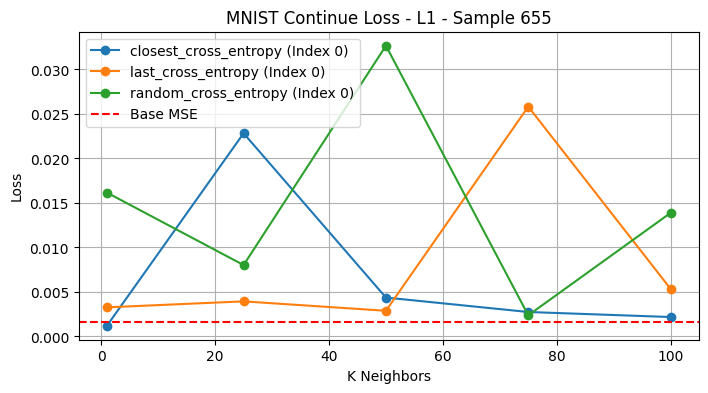

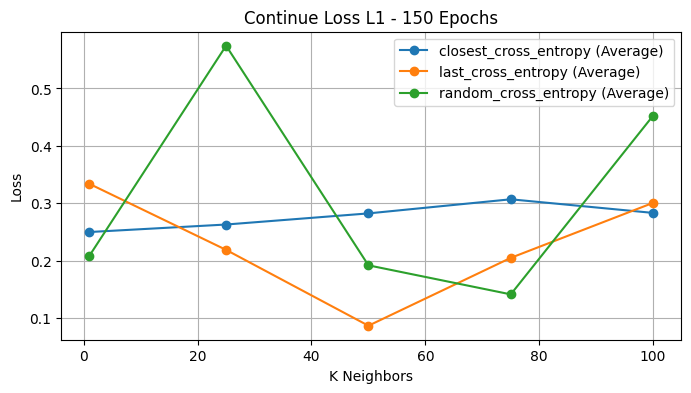

In [40]:
cross_results_l1, knn_distances_l1 = continue_entropy_for_k_and_indices_v2(trained_mnist_base, mnist_train_loader, mnist_test_loader, list_of_k, random_indices, base_epochs=base_epochs, extra_epochs=extra_epochs, metric='l1')

# Save random_indices to a file
with open('continue_data/100k/l1/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('continue_data/100k/l1/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_l1, f)

# Save knn_distances to a file
with open('continue_data/100k/l1/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_l1, f)

index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist2, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_l1, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Continue Loss - L1 - Sample {index_base}", ylabel="Loss", max_knn=101)
visualize_results(cross_results_l1, random_indices, average=True, normalize=False, title="Continue Loss L1 - 150 Epochs")



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9988      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9967      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9875      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
115

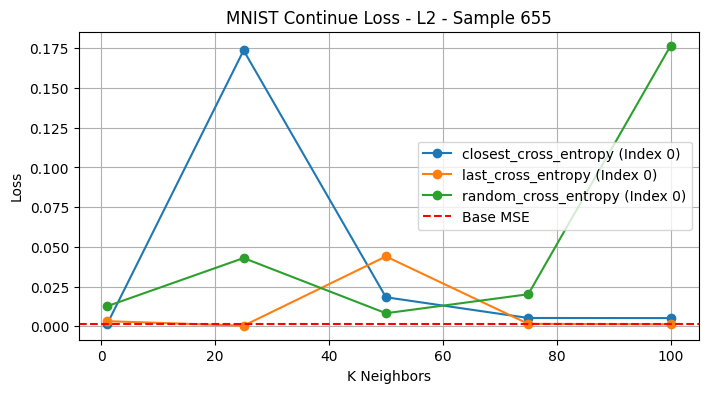

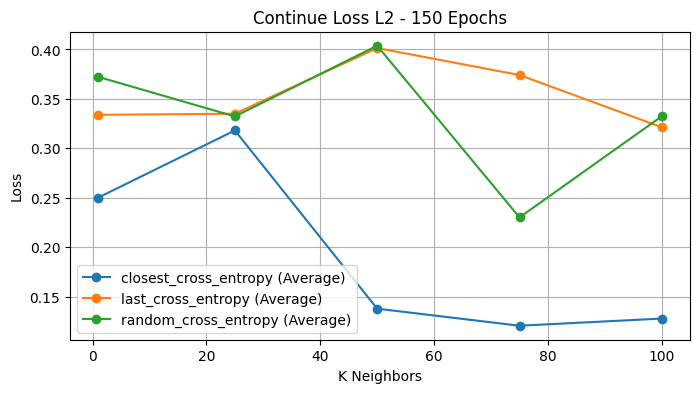

In [41]:
cross_results_l2, knn_distances_l2 = continue_entropy_for_k_and_indices_v2(trained_mnist_base, mnist_train_loader, mnist_test_loader, list_of_k, random_indices, base_epochs=base_epochs, extra_epochs=extra_epochs, metric='l2')

# Save random_indices to a file
with open('continue_data/100k/l2/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('continue_data/100k/l2/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_l2, f)

# Save knn_distances to a file
with open('continue_data/100k/l2/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_l2, f)

index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist2, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_l2, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Continue Loss - L2 - Sample {index_base}", ylabel="Loss", max_knn=101)
visualize_results(cross_results_l2, random_indices, average=True, normalize=False, title="Continue Loss L2 - 150 Epochs")



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9988      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9650      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
655    8      8      0.9993      
All seeds set to: 42
Model weights initialized with seed: 42
MNIST Predictions:
--------------------------------------------------
Index  True   Pred   Confidence  
--------------------------------------------------
115

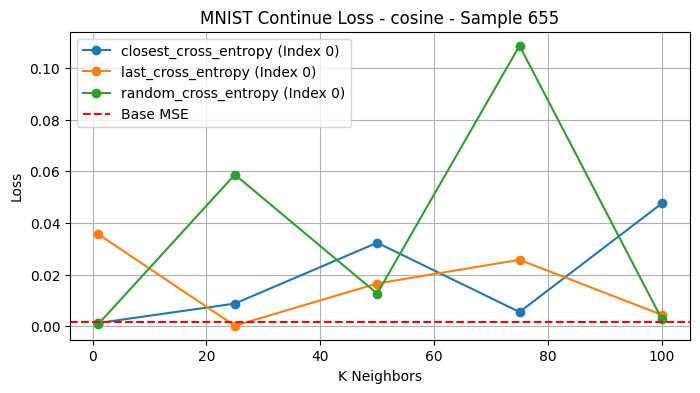

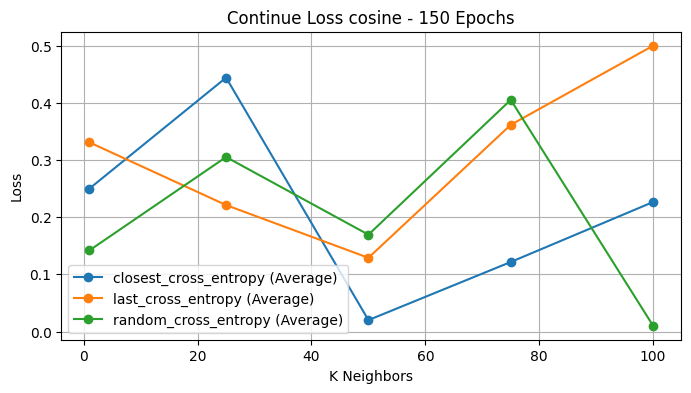

In [42]:
cross_results_cosine, knn_distances_cosine = continue_entropy_for_k_and_indices_v2(trained_mnist_base, mnist_train_loader, mnist_test_loader, list_of_k, random_indices, base_epochs=base_epochs, extra_epochs=extra_epochs, metric='cosine')

# Save random_indices to a file
with open('continue_data/100k/cosine/10_random_samples_100k.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save cross_results to a file
with open('continue_data/100k/cosine/cross_results_100k.pkl', 'wb') as f:
    pickle.dump(cross_results_cosine, f)

# Save knn_distances to a file
with open('continue_data/100k/cosine/knn_distances_100k.pkl', 'wb') as f:
    pickle.dump(knn_distances_cosine, f)

index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_mnist, probabilities_mnist, predicted_classes_mnist, sample_targets_mnist = predict_and_show(trained_mnist2, mnist_test_loader, dataset_type='mnist', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_mnist, sample_targets_mnist)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results_cosine, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"MNIST Continue Loss - cosine - Sample {index_base}", ylabel="Loss", max_knn=101)
visualize_results(cross_results_cosine, random_indices, average=True, normalize=False, title="Continue Loss cosine - 150 Epochs")

1: min=0.0260979  max=0.0747782  avg=0.0468991
25: min=0.0289826  max=0.125863  avg=0.0693283
50: min=0.0276093  max=0.117676  avg=0.0726258
75: min=0.0230291  max=0.138596  avg=0.0776687
100: min=0.0297909  max=0.129621  avg=0.0807906


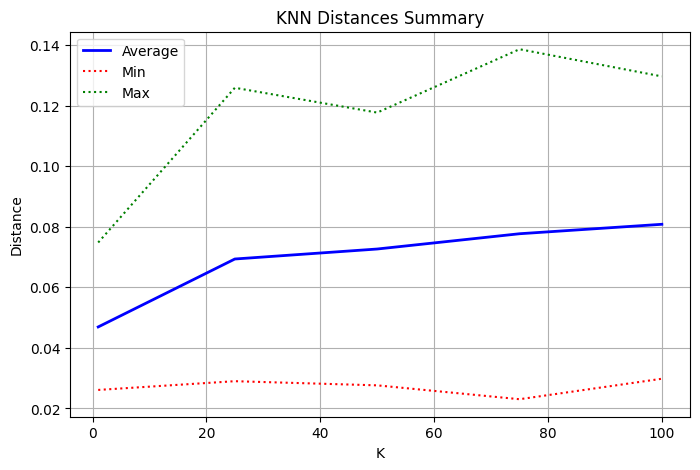

In [43]:
import statistics as stats

closest = knn_distances_cosine['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2)

# Plot min and max as dotted lines
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted")

plt.title("KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()    